<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/HI_flux_ameriflux_neon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 76.2 MB/s eta 0:00:00


In [27]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import math
import contextily as cx
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from shapely.geometry import Polygon, Point, box

import importlib, subprocess, sys
for p in ["geopandas","shapely","pyproj","fiona"]:
    try: importlib.import_module(p)
    except ImportError: subprocess.check_call([sys.executable,"-m","pip","install",p])

from shapely.affinity import translate
from pyproj import Transformer

In [2]:
df = pd.read_csv('/content/AMF_US-xPU_BASE_HH_8-5.csv')

In [3]:
df.head()

,TIMESTAMP_START,TIMESTAMP_END,CO2_MIXING_RATIO_1_1_1,H2O_MIXING_RATIO_1_1_1,CO2_MIXING_RATIO_1_1_2,CO2_1_1_2,H2O_MIXING_RATIO_1_1_2,H2O_1_1_2,CO2_MIXING_RATIO_1_1_3,CO2_1_1_3,...,PPFD_OUT,PPFD_BC_IN_1_1_1,PPFD_BC_IN_2_1_1,PPFD_BC_IN_3_1_1,G_1_1_1,G_2_1_1,G_3_1_1,THROUGHFALL_1_1_1,THROUGHFALL_2_1_1,P_1_1_1
0,2.019050e+11,2.019050e+11,414.066,23.776,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,34.02,22.67,27.71,1.507,-9999.0,3.294,0.000,0.0,0.000
1,2.019050e+11,2.019050e+11,413.915,24.453,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,32.70,22.86,27.39,1.852,-9999.0,3.534,0.000,0.0,0.000
2,2.019050e+11,2.019050e+11,414.006,24.432,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,37.48,23.21,30.62,2.115,-9999.0,3.649,0.065,0.0,0.000
3,2.019050e+11,2.019050e+11,414.939,24.216,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,24.37,17.38,21.31,-9999.000,-9999.0,-9999.000,0.000,0.0,0.000
4,2.019050e+11,2.019050e+11,416.172,24.350,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,23.42,16.28,19.84,2.564,-9999.0,5.068,0.065,0.0,0.205


In [4]:
stats = df.loc[df['FETCH_90'] != -9999.0, 'FETCH_90'].agg(['mean', 'min', 'max'])
print(stats)

mean     434.859343
min      240.000000
max     1880.000000
Name: FETCH_90, dtype: float64


The middle numbers (1–6 here) usually indicate height or level (Level 1 is lowest, Level 6 is highest).

FETCH_90 footprints, wind direction from the level closest to your EC sensor height (often the highest above-canopy measurement, so WD_1_6_1 for PUUM).

In [11]:
# Remove rows with NaN or -9999.0 in FETCH_90 or WIND_DIR
df = df.dropna(subset=["FETCH_90", "WD_1_6_1"])
df = df[(df["FETCH_90"] != -9999.0) & (df["WD_1_6_1"] != -9999.0)]

In [12]:
# Convert to radians for trig
wind_from = np.deg2rad(df["WD_1_6_1"])
wind_to = wind_from + np.pi  # reverse direction

# Compute upwind point for FETCH_90
df["x"] = df["FETCH_90"] * np.sin(wind_to)
df["y"] = df["FETCH_90"] * np.cos(wind_to)

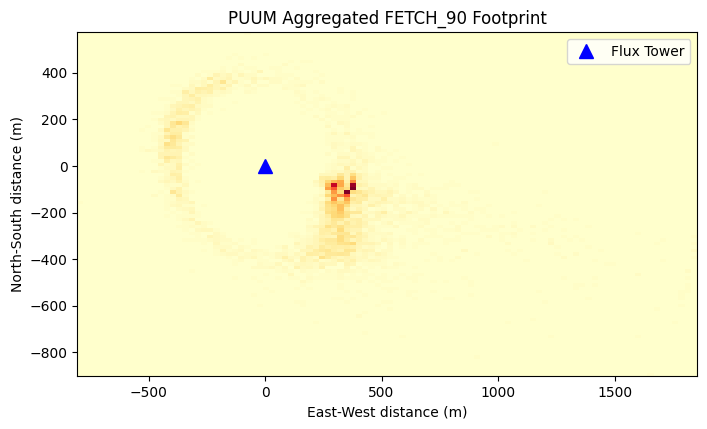

In [13]:
# Create 2D histogram
heatmap, xedges, yedges = np.histogram2d(df["x"], df["y"], bins=100)

# Plot
plt.figure(figsize=(8,8))
plt.imshow(
    heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='YlOrRd',
    aspect='equal'
)
plt.plot(0, 0, 'b^', markersize=10, label='Flux Tower')  # tower at origin
plt.xlabel("East-West distance (m)")
plt.ylabel("North-South distance (m)")
plt.title("PUUM Aggregated FETCH_90 Footprint")
plt.legend()
plt.show()


In [16]:
df = df.rename(columns={"WD_1_6_1": "WIND_DIR"})

In [17]:
# Stack points into array for KDE
coords = np.vstack([df["x"], df["y"]])
kde = gaussian_kde(coords)

# Grid for KDE evaluation
xmin, xmax = df["x"].min(), df["x"].max()
ymin, ymax = df["y"].min(), df["y"].max()
X, Y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

# Normalize to cumulative probability
Z_flat = Z.flatten()
Z_sorted = np.sort(Z_flat)[::-1]
cumsum = np.cumsum(Z_sorted) / np.sum(Z_sorted)


In [20]:
# Function to get KDE density value at a given cumulative probability
def level_for_percent(p):
    return Z_sorted[np.searchsorted(cumsum, p/100.0)]

# Get levels for 90%, 80%, 50% (note: 90% is lowest density, 50% is highest)
levels_dict = {
    "90%": level_for_percent(0.9),
    "80%": level_for_percent(0.8),
    "50%": level_for_percent(0.5)
}

# Sort by density value (lowest first) for contour plotting
sorted_items = sorted(levels_dict.items(), key=lambda x: x[1])
labels_sorted = [item[0] for item in sorted_items]
levels_sorted = [item[1] for item in sorted_items]



In [22]:
# Compute upwind source direction in degrees
df["UPWIND_DIR"] = (df["WIND_DIR"] + 180) % 360

# Assign quadrants
def quadrant(deg):
    if 0 <= deg < 90:
        return "NE"
    elif 90 <= deg < 180:
        return "SE"
    elif 180 <= deg < 270:
        return "SW"
    else:
        return "NW"

df["QUADRANT"] = df["UPWIND_DIR"].apply(quadrant)


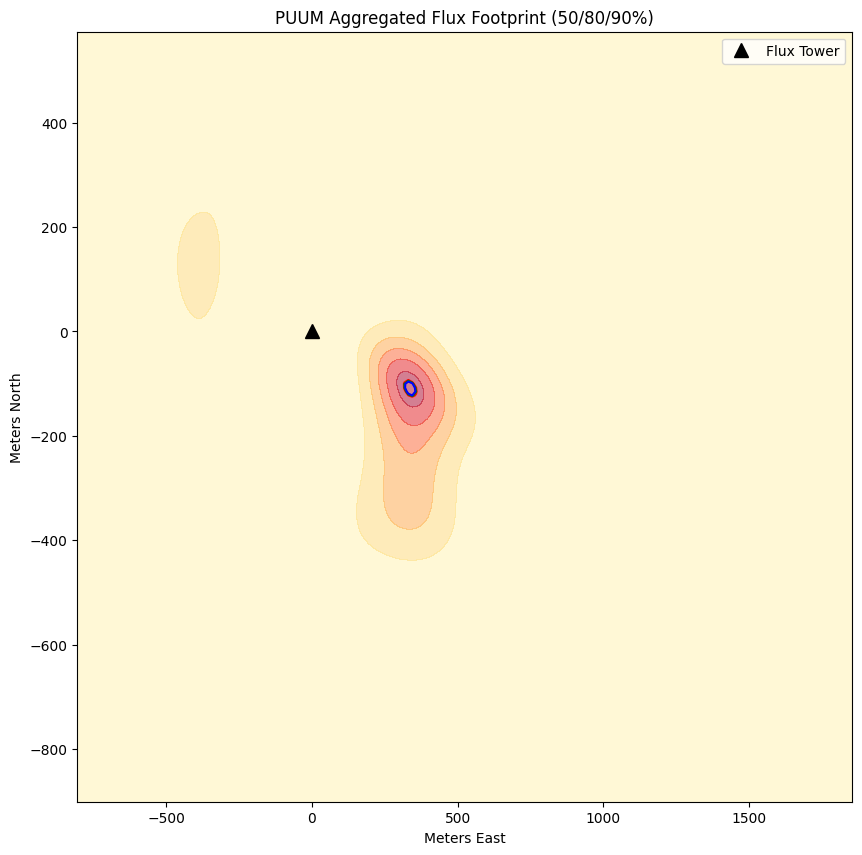

In [24]:
fig, ax = plt.subplots(figsize=(10,10))

# KDE background
ax.contourf(X, Y, Z, cmap='YlOrRd', alpha=0.5)

# Contours
cont = ax.contour(X, Y, Z, levels=levels_sorted, colors=['red', 'green', 'blue'])

# Map density values back to their percentage label
fmt = {lvl: lbl for lbl, lvl in zip(labels_sorted, levels_sorted)}

ax.clabel(cont, inline=True, fontsize=8, fmt=fmt)

# Tower marker
ax.plot(0, 0, 'k^', markersize=10, label='Flux Tower')

ax.set_xlabel("Meters East")
ax.set_ylabel("Meters North")
ax.legend()
plt.title("PUUM Aggregated Flux Footprint (50/80/90%)")
plt.show()


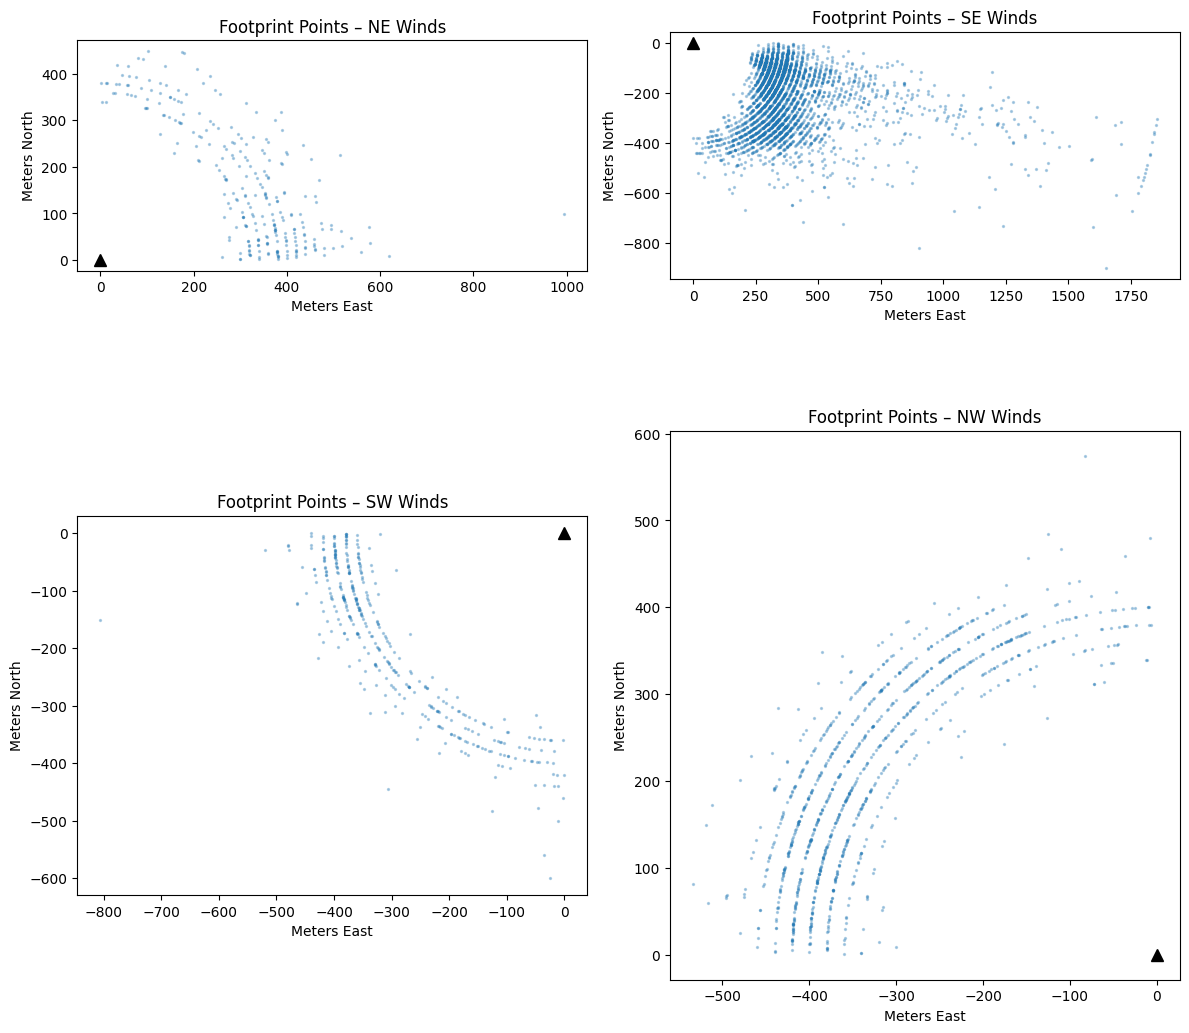

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
quadrant_list = ["NE", "SE", "SW", "NW"]

for ax, quad in zip(axes.flat, quadrant_list):
    subset = df[df["QUADRANT"] == quad]
    if len(subset) > 0:
        ax.scatter(subset["x"], subset["y"], s=2, alpha=0.3)
    ax.plot(0, 0, 'k^', markersize=8)  # Tower
    ax.set_title(f"Footprint Points – {quad} Winds")
    ax.set_xlabel("Meters East")
    ax.set_ylabel("Meters North")
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()



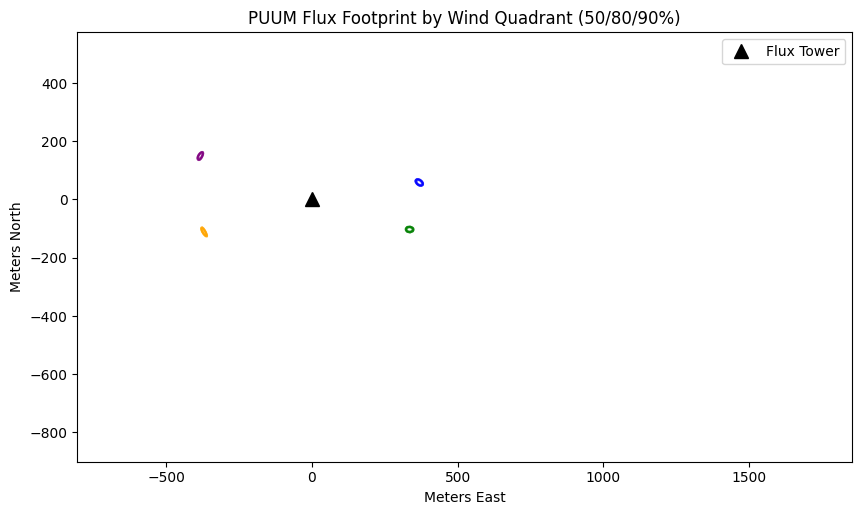

In [25]:
quadrant_colors = {
    "NE": "blue",
    "SE": "green",
    "SW": "orange",
    "NW": "purple"
}

fig, ax = plt.subplots(figsize=(10,10))

# Plot tower location
ax.plot(0, 0, 'k^', markersize=10, label='Flux Tower')

for quad, color in quadrant_colors.items():
    subset = df[df["QUADRANT"] == quad]
    if len(subset) < 20:
        continue  # skip tiny datasets

    # KDE
    coords = np.vstack([subset["x"], subset["y"]])
    kde = gaussian_kde(coords)

    # Grid
    xmin, xmax = subset["x"].min(), subset["x"].max()
    ymin, ymax = subset["y"].min(), subset["y"].max()
    X, Y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    # Cumulative density
    Z_flat = Z.flatten()
    Z_sorted = np.sort(Z_flat)[::-1]
    cumsum = np.cumsum(Z_sorted) / np.sum(Z_sorted)

    def level_for_percent(p):
        return Z_sorted[np.searchsorted(cumsum, p/100.0)]

    levels_dict = {
        "90%": level_for_percent(0.9),
        "80%": level_for_percent(0.8),
        "50%": level_for_percent(0.5)
    }
    sorted_items = sorted(levels_dict.items(), key=lambda x: x[1])
    labels_sorted = [item[0] for item in sorted_items]
    levels_sorted = [item[1] for item in sorted_items]

    # Plot contours
    cont = ax.contour(
        X, Y, Z, levels=levels_sorted,
        colors=[color]*len(levels_sorted), alpha=0.7
    )

    # Label with quadrant name instead of percentage
    ax.clabel(cont, inline=True, fontsize=7, fmt={lvl: f"{quad} {lbl}"
              for lbl, lvl in zip(labels_sorted, levels_sorted)})

ax.set_xlabel("Meters East")
ax.set_ylabel("Meters North")
ax.set_aspect('equal')
ax.set_title("PUUM Flux Footprint by Wind Quadrant (50/80/90%)")
ax.legend()
plt.show()


In [28]:
# === INPUTS ===
tower_lat, tower_lon = 19.5531, -155.3173   #
buffer_m = 25                                # padding around the extrema (meters)

# === 1) Bounding rectangle in local (meter) offsets ===
minx = float(np.nanmin(df["x"])) - buffer_m
maxx = float(np.nanmax(df["x"])) + buffer_m
miny = float(np.nanmin(df["y"])) - buffer_m
maxy = float(np.nanmax(df["y"])) + buffer_m
rect_local = box(minx, miny, maxx, maxy)     # axis-aligned rectangle that covers all footprints

# === 2) Choose a projected CRS (UTM zone from lon/lat) ===
zone = int(math.floor((tower_lon + 180) / 6) + 1)
epsg = (32600 if tower_lat >= 0 else 32700) + zone   # 326xx=N hemisphere, 327xx=S
crs_utm = f"EPSG:{epsg}"

# === 3) Shift rectangle (and tower) into real-world coordinates in that CRS ===
to_utm = Transformer.from_crs("EPSG:4326", crs_utm, always_xy=True)
x0, y0 = to_utm.transform(tower_lon, tower_lat)      # tower anchor in UTM

rect_utm = translate(rect_local, xoff=x0, yoff=y0)   # move local offsets to real coords
tower_pt = Point(x0, y0)

# === 4) Export to GeoPackage ===
gdf_rect = gpd.GeoDataFrame([{"name":"PUUM_footprint_bbox"}],
                            geometry=[rect_utm], crs=crs_utm)
gdf_tower = gpd.GeoDataFrame([{"name":"tower"}],
                             geometry=[tower_pt], crs=crs_utm)

out_gpkg = "PUUM_footprint_bbox.gpkg"
gdf_rect.to_file(out_gpkg, layer="footprint_bbox", driver="GPKG")
gdf_tower.to_file(out_gpkg, layer="tower", driver="GPKG")  # writes into same gpkg
print(f"Saved: {out_gpkg} (layers: footprint_bbox, tower)")


Saved: PUUM_footprint_bbox.gpkg (layers: footprint_bbox, tower)
